This notebook parses sgf files generated by the `match` command,
and loads them into a Pandas dataframe.

### Load libraries

In [1]:
import dataclasses
import os
import random
import re
import sys
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map

In [2]:
sys.path.append("../engines/KataGo-custom/python")

from sgfmill import sgf

### Load games

In [3]:
MATCH_DIR = "/nas/ucb/tony/go-attack/matches/visit-exp3"

RAW_SGF_STRS: List[str] = []

for sgf_file in tqdm([x for x in os.scandir(MATCH_DIR) if x.is_file()]):
    if sgf_file.name[-5:] != ".sgfs":
        continue
    with open(sgf_file.path) as f:
        for line in f.readlines():
            RAW_SGF_STRS.append(line.strip())

len(RAW_SGF_STRS)

  0%|          | 0/1603 [00:00<?, ?it/s]

74250

In [4]:
@dataclasses.dataclass
class GameInfo:
    board_size: int
    gtype: str
    start_turn_idx: int
    init_turn_num: int
    used_initial_position: bool

    b_name: str
    w_name: str

    win_color: str
    win_name: str
    lose_name: str

    komi: float  # Positive if white has the advantage

    # Number of extra stones black places at start of game,
    # equivalent to the number of white passes at start of game.
    handicap: int

    is_continuation: bool  # Whether game is continuation of previous game

    # Total number of moves (including passes)
    num_moves: int

    # How many times each player passed
    num_b_pass: int
    num_w_pass: int

    ko_rule: str
    score_rule: str
    tax_rule: str
    sui_legal: bool
    has_button: bool
    whb: str  # whiteHandicapBonus
    fpok: bool  # friendly pass ok

    sgf_str: str  # raw sgf string


def get_game_info(sgf_str: str) -> GameInfo:
    sgf_game = sgf.Sgf_game.from_string(sgf_str)

    b_name = sgf_game.get_player_name("b")
    w_name = sgf_game.get_player_name("w")

    win_color = sgf_game.get_winner()
    win_name = {"b": b_name, "w": w_name, None: None}[win_color]
    lose_name = {"b": w_name, "w": b_name, None: None}[win_color]

    if win_color is None:
        win_score = 0
    else:
        win_score = float(sgf_game.get_root().get("RE").split("+")[1])

    komi = sgf_game.get_komi()
    handicap = int(sgf_game.root.get("HA"))

    def comment_prop(
        prop_name: str,
        default=None,
    ) -> str:
        comments = sgf_game.root.get("C")
        if prop_name not in comments:
            return default
        return comments.split(f"{prop_name}=")[1].split(",")[0]

    rule_str = sgf_game.root.get("RU")

    num_b_pass: int = sum(
        node.get_move() == ("b", None) for node in sgf_game.get_main_sequence()
    )
    num_w_pass: int = sum(
        node.get_move() == ("w", None) for node in sgf_game.get_main_sequence()
    )

    return GameInfo(
        board_size=sgf_game.get_size(),
        gtype=comment_prop("gtype"),
        start_turn_idx=int(comment_prop("startTurnIdx")),
        init_turn_num=int(comment_prop("initTurnNum")),
        used_initial_position=comment_prop("usedInitialPosition") == "1",
        b_name=b_name,
        w_name=w_name,
        win_color=win_color,
        win_name=win_name,
        lose_name=lose_name,
        komi=komi,
        handicap=handicap,
        is_continuation=sgf_game.get_root().has_setup_stones(),
        num_moves=len(sgf_game.get_main_sequence()) - 1,
        num_b_pass=num_b_pass,
        num_w_pass=num_w_pass,
        sgf_str=sgf_str,
        ko_rule=re.search(r"ko([A-Z]+)", rule_str).group(1),
        score_rule=re.search(r"score([A-Z]+)", rule_str).group(1),
        tax_rule=re.search(r"tax([A-Z]+)", rule_str).group(1),
        sui_legal=re.search(r"sui([0-9])", rule_str).group(1) == "1",
        has_button="button1" in rule_str,
        whb=re.search(r"whb([A-Z0-9\-]+)", rule_str).group(1)
        if "whb" in rule_str
        else "0",
        fpok="fpok" in rule_str,
    )


random.seed(42)
GAME_INFOS: List[GameInfo] = process_map(
    get_game_info,
    RAW_SGF_STRS,
    max_workers=64,
    chunksize=50,
)

  0%|          | 0/74250 [00:00<?, ?it/s]

In [5]:
%%time
df = pd.DataFrame([dataclasses.asdict(gi) for gi in GAME_INFOS])
print("gtypes:", df.gtype.unique())
print("Number of cleanup games:", (df.gtype == "cleanuptraining").sum())

# Filter to only normal games
df = df[(df.gtype == "normal")]
print("Fraction continuation:    ", df.is_continuation.mean())
print("Fraction used_initial_pos:", df.used_initial_position.mean())
print("max(init_turn_num)       :", df.init_turn_num.max())

df.head()

gtypes: ['normal']
Number of cleanup games: 0
Fraction continuation:     0.0
Fraction used_initial_pos: 0.0
max(init_turn_num)       : 0
CPU times: user 2.9 s, sys: 86.8 ms, total: 2.99 s
Wall time: 2.99 s


,board_size,gtype,start_turn_idx,init_turn_num,used_initial_position,b_name,w_name,win_color,win_name,lose_name,...,num_b_pass,num_w_pass,ko_rule,score_rule,tax_rule,sui_legal,has_button,whb,fpok,sgf_str
0,19,normal,0,0,False,cp127-v512,cp127-v8,b,cp127-v512,cp127-v8,...,1,17,POSITIONAL,AREA,NONE,True,False,0,False,(;FF[4]GM[1]SZ[19]PB[cp127-v512]PW[cp127-v8]HA...
1,19,normal,0,0,False,cp79-v512,cp63-v16,b,cp79-v512,cp63-v16,...,1,34,POSITIONAL,AREA,NONE,True,False,0,False,(;FF[4]GM[1]SZ[19]PB[cp79-v512]PW[cp63-v16]HA[...
2,19,normal,0,0,False,cp127-v256,cp127-v32,b,cp127-v256,cp127-v32,...,1,7,POSITIONAL,AREA,NONE,True,False,0,False,(;FF[4]GM[1]SZ[19]PB[cp127-v256]PW[cp127-v32]H...
3,19,normal,0,0,False,cp63-v512,cp63-v32,b,cp63-v512,cp63-v32,...,1,12,POSITIONAL,AREA,NONE,True,False,0,False,(;FF[4]GM[1]SZ[19]PB[cp63-v512]PW[cp63-v32]HA[...
4,19,normal,0,0,False,cp79-v512,cp99-v4,b,cp79-v512,cp99-v4,...,1,4,POSITIONAL,AREA,NONE,True,False,0,False,(;FF[4]GM[1]SZ[19]PB[cp79-v512]PW[cp99-v4]HA[0...


### Helper functions

In [10]:
@dataclasses.dataclass
class SGFUrl:
    sgf: str
    text: str

    def sgf_str_to_url(self, sgf_str: str) -> str:
        return f"https://humancompatibleai.github.io/sgf-viewer/#sgf={sgf_str}"

    def __post_init__(self):
        self.url = self.sgf_str_to_url(self.sgf)

    def _repr_html_(self):
        """HTML link to this URL."""
        return f'<a href="{self.url}">{self.text}</a>'

    def __str__(self):
        """Return the underlying string."""
        return self.url

### Analyze data

<AxesSubplot:>

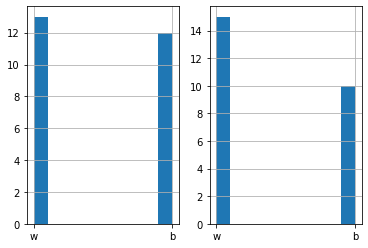

In [11]:
plt.subplot(1, 2, 1)
df[(df.b_name == "cp127-v1") & (df.w_name == "cp63-v1024")].win_color.hist()

plt.subplot(1, 2, 2)
df[(df.w_name == "cp127-v1") & (df.b_name == "cp63-v1024")].win_color.hist()

In [12]:
cur_df = df[(df.win_name == "cp63-v1024") & (df.lose_name == "cp127-v1")]
len(cur_df)

23

In [15]:
SGFUrl(sgf=cur_df.sgf_str.iloc[2], text="cp63-v1024 beats cp127-v1 (game2)")

SGFUrl(sgf='(;FF[4]GM[1]SZ[19]PB[cp127-v1]PW[cp63-v1024]HA[0]KM[6.5]RU[koPOSITIONALscoreAREAtaxNONEsui1]RE[W+61.5]C[startTurnIdx=0,initTurnNum=0,gameHash=8AFE22B447660E676A8DAF8CF0FCCA28,gtype=normal,bTimeUsed=4.84243,wTimeUsed=1552.48];B[pd]C[0.44 0.56 0.00 -0.6 v=1];W[dq]C[0.50 0.50 0.00 -0.4 v=1024];B[dd]C[0.42 0.58 0.00 -1.1 v=1];W[pq]C[0.50 0.50 0.00 -0.1 v=1024];B[co]C[0.42 0.58 0.00 -1.3 v=1];W[po]C[0.51 0.49 0.00 -0.0 v=1024];B[fp]C[0.43 0.57 0.00 -1.1 v=1];W[ep]C[0.50 0.50 0.00 -0.5 v=1024];B[eo]C[0.44 0.56 0.00 -0.8 v=1];W[fo]C[0.50 0.50 0.00 -0.5 v=1024];B[en]C[0.40 0.60 0.00 -1.4 v=1];W[fq]C[0.49 0.51 0.00 -0.6 v=1024];B[gp]C[0.35 0.65 0.00 -2.3 v=1];W[gq]C[0.49 0.51 0.00 -0.7 v=1024];B[hp]C[0.30 0.70 0.00 -3.6 v=1];W[cp]C[0.48 0.52 0.00 -1.0 v=1024];B[hq]C[0.27 0.73 0.00 -4.7 v=1];W[bo]C[0.51 0.49 0.00 0.0 v=1024];B[bn]C[0.26 0.74 0.00 -4.9 v=1];W[qc]C[0.47 0.53 0.00 -1.5 v=1024];B[bp]C[0.21 0.79 0.00 -5.8 v=1];W[do]C[0.48 0.52 0.00 -1.4 v=1024];B[cn]C[0.19 0.81 0.00 -6.5 v=1];W[bq]C[0.49 0.51 0.00 -0.6 v=1024];B[pc]C[0.17 0.83 0.00 -7.1 v=1];W[qd]C[0.49 0.51 0.00 -0.8 v=1024];B[pe]C[0.18 0.82 0.00 -6.9 v=1];W[qe]C[0.49 0.51 0.00 -0.9 v=1024];B[qf]C[0.19 0.81 0.00 -6.4 v=1];W[rf]C[0.49 0.51 0.00 -0.8 v=1024];B[cf]C[0.17 0.83 0.00 -7.0 v=1];W[dg]C[0.48 0.52 0.00 -1.0 v=1024];B[cg]C[0.17 0.83 0.00 -7.4 v=1];W[di]C[0.49 0.51 0.00 -0.8 v=1024];B[ao]C[0.16 0.84 0.00 -7.7 v=1];W[qg]C[0.48 0.52 0.00 -1.0 v=1024];B[pf]C[0.15 0.85 0.00 -7.8 v=1];W[dc]C[0.48 0.52 0.00 -1.1 v=1024];B[ec]C[0.13 0.87 0.00 -9.0 v=1];W[ed]C[0.47 0.53 0.00 -1.6 v=1024];B[fc]C[0.11 0.89 0.00 -9.3 v=1];W[de]C[0.51 0.49 0.00 0.4 v=1024];B[cd]C[0.14 0.86 0.00 -8.0 v=1];W[ce]C[0.52 0.48 0.00 0.7 v=1024];B[df]C[0.15 0.85 0.00 -7.9 v=1];W[ee]C[0.52 0.48 0.00 0.5 v=1024];B[cc]C[0.17 0.83 0.00 -7.8 v=1];W[bd]C[0.51 0.49 0.00 0.3 v=1024];B[ef]C[0.12 0.88 0.00 -10.1 v=1];W[bc]C[0.52 0.48 0.00 0.8 v=1024];B[cb]C[0.09 0.91 0.00 -11.4 v=1];W[ge]C[0.53 0.47 0.00 1.0 v=1024];B[fg]C[0.06 0.94 0.00 -13.1 v=1];W[hd]C[0.53 0.47 0.00 0.9 v=1024];B[hb]C[0.04 0.96 0.00 -15.1 v=1];W[bb]C[0.52 0.48 0.00 0.8 v=1024];B[db]C[0.07 0.93 0.00 -12.0 v=1];W[bf]C[0.52 0.48 0.00 0.7 v=1024];B[bg]C[0.05 0.95 0.00 -14.2 v=1];W[fj]C[0.53 0.47 0.00 0.8 v=1024];B[hf]C[0.04 0.96 0.00 -17.2 v=1];W[gf]C[0.52 0.48 0.00 0.8 v=1024];B[gg]C[0.03 0.97 0.00 -17.4 v=1];W[hg]C[0.52 0.48 0.00 0.8 v=1024];B[if]C[0.03 0.97 0.00 -16.4 v=1];W[hh]C[0.54 0.46 0.00 1.5 v=1024];B[gi]C[0.05 0.95 0.00 -14.7 v=1];W[gh]C[0.57 0.43 0.00 3.4 v=1024];B[fh]C[0.08 0.92 0.00 -11.9 v=1];W[fi]C[0.58 0.42 0.00 3.6 v=1024];B[bi]C[0.12 0.88 0.00 -10.5 v=1];W[cj]C[0.57 0.43 0.00 3.1 v=1024];B[af]C[0.08 0.92 0.00 -13.3 v=1];W[be]C[0.56 0.44 0.00 2.5 v=1024];B[hi]C[0.09 0.91 0.00 -12.6 v=1];W[jg]C[0.60 0.40 0.00 4.9 v=1024];B[bj]C[0.09 0.91 0.00 -12.8 v=1];W[jf]C[0.60 0.40 0.00 4.6 v=1024];B[gk]C[0.08 0.92 0.00 -12.9 v=1];W[ck]C[0.59 0.41 0.00 4.6 v=1024];B[dh]C[0.07 0.93 0.00 -12.3 v=1];W[ch]C[0.61 0.39 0.00 5.8 v=1024];B[eh]C[0.23 0.77 0.00 -6.2 v=1];W[ci]C[0.62 0.38 0.00 6.7 v=1024];B[bh]C[0.09 0.91 0.00 -11.7 v=1];W[gj]C[0.60 0.40 0.00 5.3 v=1024];B[hj]C[0.07 0.93 0.00 -13.3 v=1];W[hk]C[0.61 0.39 0.00 5.6 v=1024];B[ji]C[0.09 0.91 0.00 -11.9 v=1];W[jh]C[0.64 0.36 0.00 8.0 v=1024];B[gl]C[0.12 0.88 0.00 -9.6 v=1];W[hl]C[0.70 0.30 0.00 11.1 v=1024];B[hm]C[0.18 0.82 0.00 -7.3 v=1];W[im]C[0.53 0.47 0.00 2.2 v=1024];B[gm]C[0.19 0.81 0.00 -7.1 v=1];W[jj]C[0.53 0.47 0.00 2.0 v=1024];B[ii]C[0.22 0.78 0.00 -8.3 v=1];W[ki]C[0.97 0.03 0.00 35.5 v=1024];B[ik]C[0.45 0.55 0.00 0.7 v=1];W[il]C[0.96 0.04 0.00 36.8 v=1024];B[jk]C[0.63 0.37 0.00 6.8 v=1];W[kj]C[0.96 0.04 0.00 36.7 v=1024];B[ij]C[0.88 0.12 0.00 21.3 v=1];W[kl]C[0.97 0.03 0.00 36.8 v=1024];B[ie]C[0.92 0.08 0.00 28.6 v=1];W[hc]C[0.97 0.03 0.00 40.7 v=1024];B[je]C[0.99 0.01 0.00 35.1 v=1];W[ib]C[0.97 0.03 0.00 41.7 v=1024];B[gb]C[0.99 0.01 0.00 37.4 v=1];W[jc]C[0.98 0.02 0.00 45.4 v=1024];B[lc]C[1.00 0.00 0.00 38.9 v=1];W[kd]C[0.97 0.03 0.00 44.4 v=1024];B[ke]C[1.00 0.00 0.00